# SegNet1 Model Development
* this marks the first attempt at training a segmentation model

In [1]:
#################### Imports #########################
from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
from torch.optim import lr_scheduler
import time
import numpy as np
from torch.autograd import Variable
from pathlib import Path
from PIL import Image
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# imports copied for loading in data
import os
import torch
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
multiGPU = False

In [2]:
# define variables if GPU is to be used
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

Using GPU


In [43]:
!git clone https://github.com/trypag/pytorch-unet-segnet       

Cloning into 'pytorch-unet-segnet'...
remote: Enumerating objects: 97, done.
remote: Total 97 (delta 0), reused 0 (delta 0), pack-reused 97
Unpacking objects: 100% (97/97), done.


In [7]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

In [3]:
######## unedited data class
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [4]:
###### unedited import
base_path = Path('38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)


8400

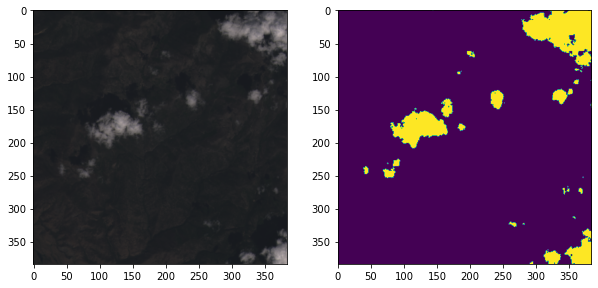

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(150))
ax[1].imshow(data.open_mask(150))

In [6]:
####### Split the data
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([4, 4, 384, 384]), torch.Size([4, 384, 384]))

In [7]:
################ Import the model class ###############
from segnet1 import SegNet

In [12]:
################ Initialise Model ###############
learning_rate = 1e-3
num_classes = 2 # assuming cloud and non cloud
num_channels = 4 # for the cloud data, for now
model = SegNet(num_classes,n_init_features=num_channels)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)                 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
  model.cuda()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

In [13]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape
pred = model(xb.cuda())
pred.shape

torch.Size([4, 2, 384, 384])

# Training Function Source
https://www.kaggle.com/cordmaur/38-cloud-simple-unet

In [14]:
######## train function 
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, scheduler, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

In [16]:
#### training attempt 1

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt, exp_lr_scheduler, acc_metric, epochs=5)

Epoch 0/4
----------


RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 14.73 GiB total capacity; 4.89 GiB already allocated; 92.88 MiB free; 4.93 GiB reserved in total by PyTorch)
Exception raised from malloc at /opt/conda/conda-bld/pytorch_1595629411241/work/c10/cuda/CUDACachingAllocator.cpp:272 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x4d (0x7f2cc176577d in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x20626 (0x7f2cc19bd626 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x214f4 (0x7f2cc19be4f4 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x21b81 (0x7f2cc19beb81 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #4: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x249 (0x7f2cc48cdc79 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xd25dc9 (0x7f2cc28f0dc9 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xd3fbf7 (0x7f2cc290abf7 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0xe450dd (0x7f2cf4a240dd in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xe453f7 (0x7f2cf4a243f7 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::empty(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0xfa (0x7f2cf4b2ee7a in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::TensorIterator::fast_set_up(at::TensorIteratorConfig const&) + 0x56a (0x7f2cf47bc3ea in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #11: at::TensorIterator::build(at::TensorIteratorConfig&) + 0x76 (0x7f2cf47c0456 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::TensorIterator::TensorIterator(at::TensorIteratorConfig&) + 0xdd (0x7f2cf47c0abd in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::TensorIterator::binary_op(at::Tensor&, at::Tensor const&, at::Tensor const&, bool) + 0x14a (0x7f2cf47c0c6a in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x1749780 (0x7f2cc3314780 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #15: at::native::threshold_backward_cuda(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x4f (0x7f2cc331625f in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0xd16740 (0x7f2cc28e1740 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #17: <unknown function> + 0x7f66b4 (0x7f2cf43d56b4 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #18: at::threshold_backward(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x183 (0x7f2cf4b06703 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2c6fd8f (0x7f2cf684ed8f in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #20: <unknown function> + 0x7f66b4 (0x7f2cf43d56b4 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #21: at::threshold_backward(at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x183 (0x7f2cf4b06703 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::generated::ReluBackward1::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x1a9 (0x7f2cf667aa19 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #23: <unknown function> + 0x30d1017 (0x7f2cf6cb0017 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #24: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7f2cf6cab860 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #25: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7f2cf6cac401 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #26: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7f2cf6ca4579 in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #27: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7f2cfafce1ba in /opt/conda/envs/pytorch/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #28: <unknown function> + 0xc9067 (0x7f2d3c535067 in /opt/conda/envs/pytorch/bin/../lib/libstdc++.so.6)
frame #29: <unknown function> + 0x74a4 (0x7f2d3f6c84a4 in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #30: clone + 0x3f (0x7f2d3f40ad0f in /lib/x86_64-linux-gnu/libc.so.6)


In [22]:
torch.cuda.is_available()

True

# Training Observations
* It seems that within each 100 steps, the accuracy is heavily biased by the black images, as if these appear, then the accuracy is skewed to a very high level. But it fact with pictures that have a lot of clouds, the accuracy is quite low. 
* To see this effect more closely, should seperate out the exmaples that have a high proportion of cloud in the images, and see how the model runs on those. 

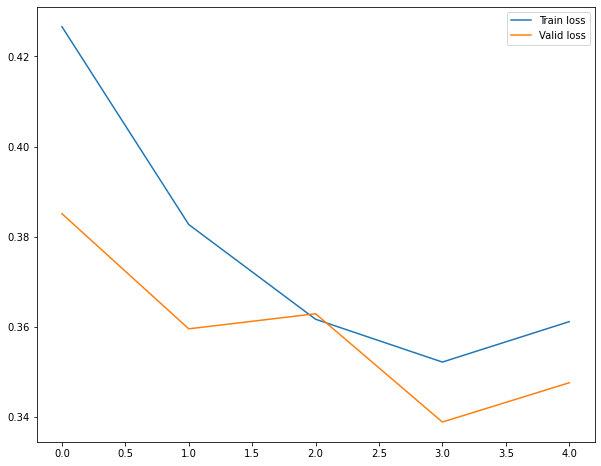

In [15]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [16]:
######## now to view some of the predictions
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [26]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

torch.Size([4, 2, 384, 384])

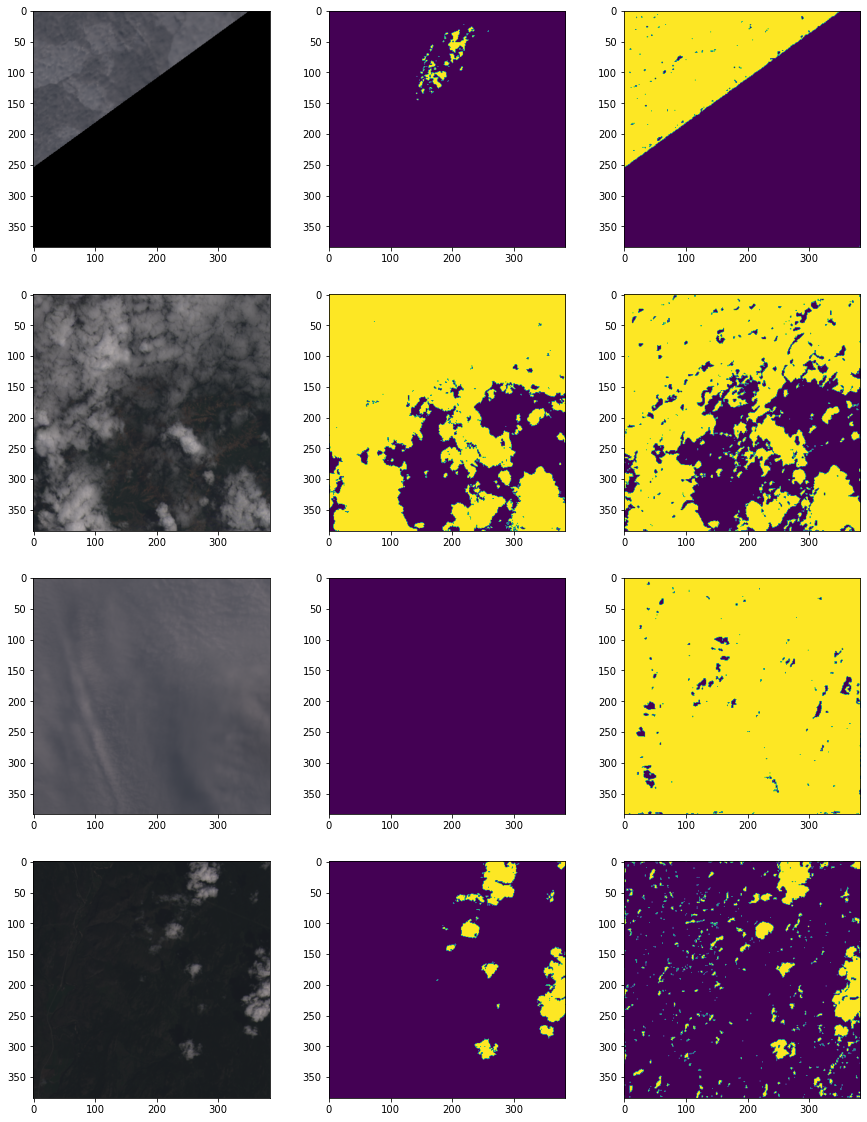

In [27]:
bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

# Training Attempt 2
* batch size 12
* epochs 30

In [11]:
####### Split the data
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 4, 384, 384]), torch.Size([12, 384, 384]))

In [12]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=30)

Epoch 29/29
----------
valid Loss: 0.1529 Acc: 0.9554362297058105
----------
Training complete in 277m 57s


In [13]:
########## Assess the results
######## now to view some of the predictions
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [14]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

torch.Size([12, 2, 384, 384])

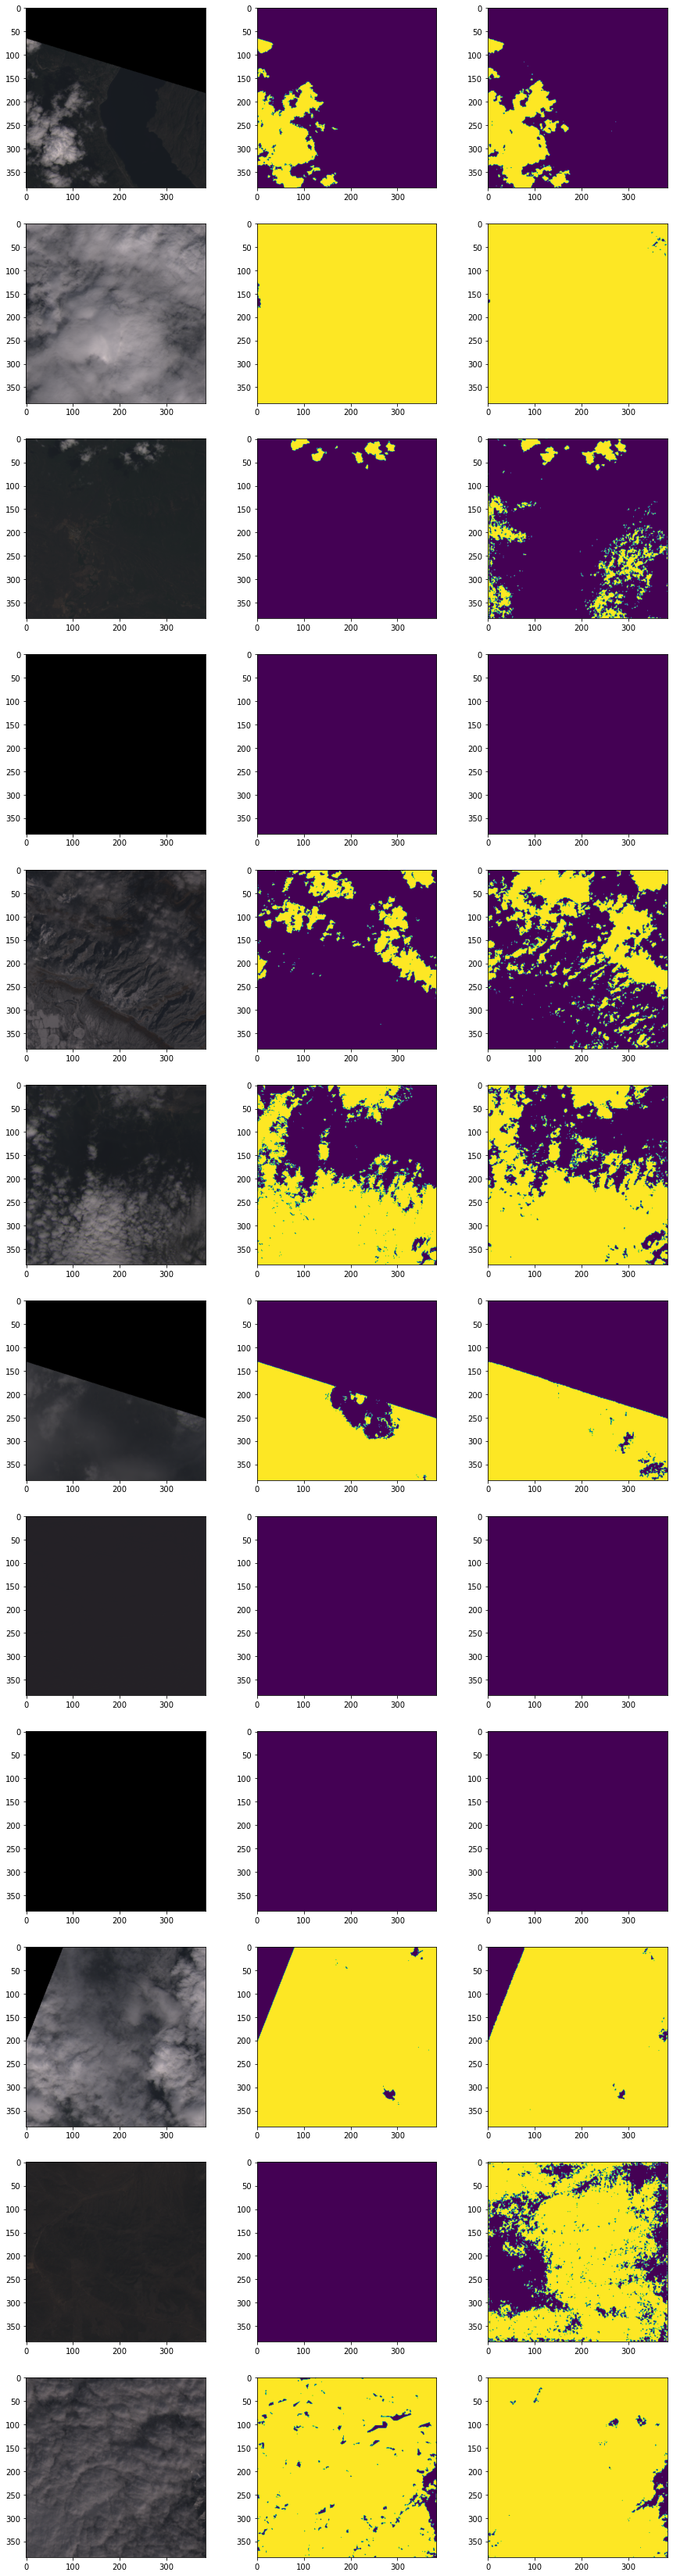

In [15]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

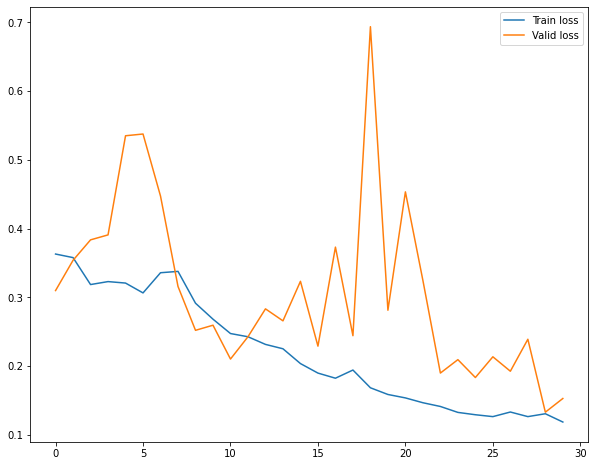

In [16]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

# Training for 50 epochs
Just realised it was commented out before, not sure why that was the case. The training loss seemed to be going down adequately. 
* training on batch size of 12
* training for 50 epochs to see how well it progresses after 30

## Tensorboard
* On this traning go I'm trying tensorbaord for the first time 
* The code that sets it up is below 

In [10]:
epochs=50

####### Split the data
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)
xb, yb = next(iter(train_dl))

# load the model in and train it again.
num_classes = 2 # assuming cloud and non cloud
num_channels = 4 # for the cloud data, for now
model = SegNet(num_classes,n_init_features=num_channels)


if torch.cuda.is_available():
  model.cuda()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)                              
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt, exp_lr_scheduler, acc_metric, epochs=epochs)

RuntimeError: CUDA error: out of memory

In [ ]:
######## Save the model 

# Specify a path
PATH = "SegNet1_state_dict_model.pt"


torch.save(model.state_dict(), PATH)     # saves the model wegiths


# To load
'''
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''


PATH = "SegNet1_model.pt"



############# Alternatively

torch.save(model, PATH)                  # saves the model weighs ane model
# To load
'''
model = torch.load(PATH)
model.eval()
'''

In [ ]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [ ]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

In [ ]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [ ]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

# SET UP PRIOR TO TRAINING ABOVE 🚨🚨🚨🚨🚨🚨🚨

# TensorBoard visualisation
* tool for visualising the logdir 
* just learning how to use it

In [11]:
!pip install tensorboard

     |████████████████████████████████| 6.8 MB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 68.0 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 59.1 MB/s eta 0:00:01


In [ ]:
##### Start up the tensorbaord, get link to visualisation here
!pytorch tensorboard --logdir=runs

In [ ]:
############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/segnet1')
# img_grid = torchvision.utils.make_grid(example_data)
#writer.add_image('mnist_images', img_grid)

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

# adds a visualisation of the model archetecture
writer.add_graph(model, xb)

#writer.close() # makes sure teh outputs are being flushed there
#sys.exit()
###################################################

In [14]:
print(model)

SegNet(
  (encoders): ModuleList(
    (0): _Encoder(
      (features): Sequential(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): _Encoder(
      (features): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): _Encoder(
 

In [ ]:
######## train function from UNET kaggle page +++++ with modifications for tensorboard visualisation
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, scheduler, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0
    summary_acc = 0.0
    summary_loss = 0.0
    n_total_steps = len(train_loader)

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 
                
                # metrics for tensorbaord 
                summary_acc += acc
                summary_loss += loss

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
                    writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
                    writer.add_scalar('accuracy', summary_acc / 100, epoch * n_total_steps + i)
                    summary_acc = 0.0
                    summary_loss = 0.0

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()